In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import autograd.numpy as np
from autograd import grad, jacobian
from scipy import optimize as opt
# import numba
from functools import lru_cache
import warnings
import seaborn as sns
sns.set(
    style='ticks'
)

from rakott.mpl import fig_xlabel, fig_ylabel, fig_panel_labels, savefig_bbox, legend_out

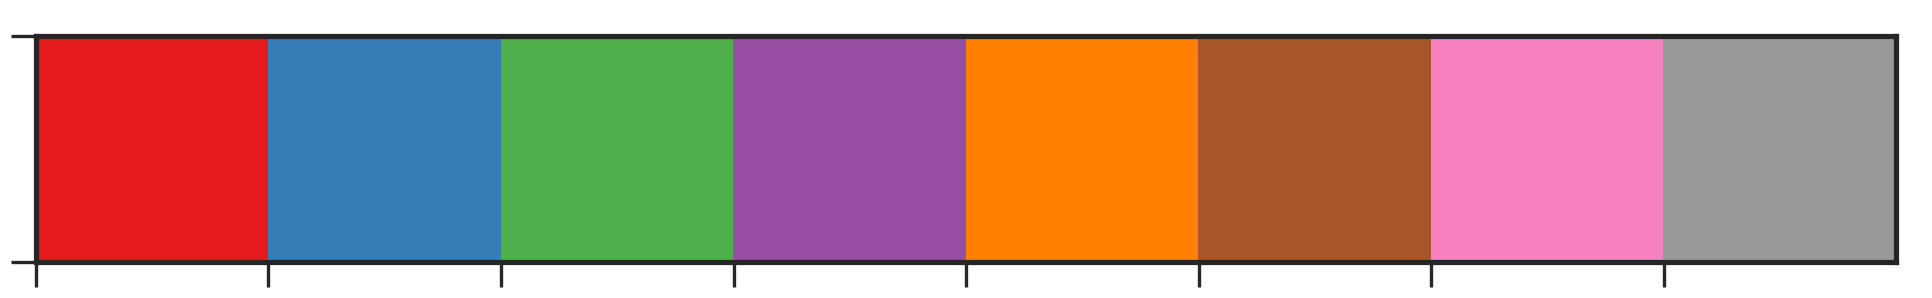

In [231]:
sns.set(style='ticks', context='paper', palette='deep')

default_palette = sns.color_palette()
colors = sns.color_palette("Set1", 9)
red, blue, green, purple, orange, yellow, brown, pink, gray = colors
colors = red, blue, green, purple, orange, brown, pink, gray
sns.palplot(colors)

width, height = plt.rcParams['figure.figsize']
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.dpi'] = 300
cntr_fontsize = 14

In [2]:
def is_polymorphism(w, ρ, k, l):
    # see eq 22
    s = 1 - w
    if ρ*s == 0:
        return True
    elif k == l:
        return True
    elif l > k:
        return l/k < -np.log(1+ρ*s/(1-s))/np.log(1-ρ*s) 
    else: # k > l
        return k/l < -np.log(1+ρ*s/(1-s))/np.log(1-ρ*s) 

In [3]:
W = 1.0
w = 0.1
ρ = 0.5
P = 0.2

In [4]:
def f1(x, wA, wB, ρ, dx=0):    
    wbar = x * wA + (1 - x) * wB
    x = ρ * x * wA/wbar + (1 - ρ) * x
    if dx > 0:
        x += dx * np.sign(wB - wA)
    return x
# nf1 = numba.jit(f1)
df1 = grad(f1)

x = 0.25
print('f1(0.25) =', f1(0.25, W, w, ρ))
print('df1(0.25) =', df1(0.25, W, w, ρ))

dx = 1e-4
assert np.isclose(f1(x + dx, W, w, ρ, dx=1e-10), f1(x, W, w, ρ, dx=1e-10) + df1(x, W, w, ρ, dx=1e-10) * dx)

f1(0.25) = 0.5096153846153846
df1(0.25) = 0.9733727810650887


In [13]:
%timeit f1(x, W, w, ρ)
%timeit df1(x, W, w, ρ)

430 ns ± 9.32 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
303 µs ± 52.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [5]:
def F1(x, W, w, ρ, k, l, dx=0): 
    for _ in range(k):
        x = f1(x, W, w, ρ, dx=dx)
    for _ in range(l):
        x = f1(x, w, W, ρ, dx=dx)
    return x
# nF1 = numba.jit(F1)
dF1 = jacobian(F1)

assert np.isclose(F1(x + dx, W, w, ρ, 1, 1, dx=1e-10), F1(x, W, w, ρ, 1, 1, dx=1e-10) + dF1(x, W, w, ρ, 1, 1, dx=1e-10) * dx)

In [ ]:
%timeit F1(x, W, w, ρ, 2, 2)
%timeit nF1(x, W, w, ρ, 2, 2)
%timeit dF1(x, W, w, ρ, 2, 2)

# Stability of phenotypes with a single modifier

In [6]:
w, k, l = 0.1, 10, 10
ρ = 0.1

In [7]:
xs = np.linspace(1e-10, 1-1e-10, 1001)
ys = np.array([F1(x, 1, w, ρ, k, l) for x in xs])
dys = np.array([dF1(x, 1, w, ρ, k, l) for x in xs])
argdy0 = dys.argmin()
argy0 = abs(ys-xs)[1:-1].argmin() + 1

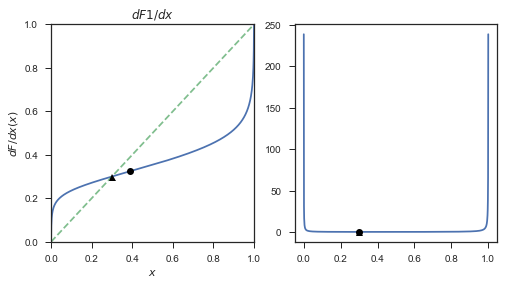

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].plot(xs, ys)
axes[0].plot(xs, xs, ls='--', alpha=0.75)
axes[0].plot(xs[argy0], ys[argy0], '^k')
axes[0].plot(xs[argdy0], ys[argdy0], 'ok')
axes[0].set(title=r'$F1(x)$', xlabel='$x$', ylabel='$F(x)$', xlim=(0,1), ylim=(0,1))
axes[1].plot(xs, dys)
axes[1].plot(xs[argy0], ys[argy0], '^k')
axes[1].plot(xs[argy0], dys[argy0], 'ok')
axes[0].set(title=r'$dF1/dx$', xlabel='$x$', ylabel='$dF/dx(x)$', xlim=(0,1));

In [9]:
def stablex1_opt(W, w, ρ, k, l, x0=0.5, dx=0):    
    def obj(x, W, w, ρ, k, l):
        return abs(F1(x, W, w, ρ, k, l, dx=dx) - x)
    jac = grad(obj)
#     nobj = numba.jit(obj)
    res = opt.minimize(obj, x0, (1, w, ρ, k, l), jac=jac, method='TNC', bounds=((0, 1),))
    assert res.success, res
    assert np.isclose(F1(res.x, W, w, ρ, k, l), res.x), '{}->{}'.format(res.x, F1(res.x, W, w, ρ, k, l))
    return res.x[0]

In [10]:
x = stablex1_opt(W, w, ρ, k, l)
np.isclose(x, F1(x, W, w, ρ, k, l))

True

In [12]:
# @numba.jit()
def stablex1_itr(W, w, ρ, k, l, x0=0.5, dx=0):
    x = x0
    x_prev = -1
    while not np.isclose(x, x_prev):
        x, x_prev = F1(x, W, w, ρ, k, l, dx=dx), x
#     assert np.isclose(F1(x, W, w, ρ, k, l, dx=dx), x)
    return x

In [13]:
x = stablex1_itr(W, w, ρ, k, l, dx=1e-8)
np.isclose(x, F1(x, W, w, ρ, k, l, dx=1e-8))

True

In [ ]:
%timeit stablex1_opt(W, w, ρ, k, l)
%timeit stablex1_itr(W, w, ρ, k, l)

In [14]:
xopt, xitr = stablex1_opt(W, w, ρ, k, l), stablex1_itr(W, w, ρ, k, l)

In [15]:
xopt, F1(xopt, W, w, ρ, k, l, dx=1e-8)

(0.30029859972974937, 0.30029863444491928)

In [16]:
xitr, F1(xitr, W, w, ρ, k, l, dx=1e-8)

(0.30029904807741636, 0.3002987569706792)

In [17]:
stablex1 = lru_cache()(stablex1_itr)

In [ ]:
%timeit stablex1_itr(W, w, ρ, k, l)
%timeit stablex1(W, w, ρ, k, l)

# Stability of modifiers

In [18]:
W, w = 1.0, 0.5
k, l = 1, 1
ρ, P = 0.1, 0.9

In [19]:
A = np.array([1.0, 0.0, 1.0, 0.0])
B = np.array([0.0, 1.0, 0.0, 1.0])

def Tf2(x, wA, wB, ρ, P):
    S = A * wA + B * wB
    xA = A @ x
    xB = B @ x
    wbar = S @ x
    S = np.diag(S) / wbar

    Q = np.array(
        [[xA, xA, 0, 0],
         [xB, xB, 0, 0],
         [0, 0, xA, xA],
         [0, 0, xB, xB]])
    r = np.array([ρ, ρ, P, P])
    R = Q @ np.diag(1-r) + np.diag(r)
    assert np.allclose(R.sum(axis=0), 1), R.sum(axis=1)
    
    return R @ S

def f2(x, wA, wB, ρ, P, dx=0):
    x = Tf2(x, wA, wB, ρ, P) @ x
    if dx > 0:
        dv = dx * np.array([wB-wA, wA-wB, wB-wA, wA-wB])
        x += dv
    return x

# nf2 = numba.jit(f2)
df2 = jacobian(f2)

x = np.array([0.7, 0.3, 0.0, 0.0])
print('f2(x) =', f2(x, W, w, ρ, P))
print('df2(x) =', df2(x, W, w, ρ, P))

dx = np.array([0.001, -0.001, 0, 0])
assert np.allclose(f2(x+dx, W, w, ρ, P, dx=1e-10), f2(x, W, w, ρ, P, dx=1e-10) + df2(x, W, w, ρ, P, dx=1e-10) @ dx)

f2(x) = [ 0.71235294  0.28764706  0.          0.        ]
df2(x) = [[ 0.92076125 -0.04844291  0.06193772 -0.41903114]
 [-0.02076125  0.94844291 -0.3384083   0.73079585]
 [ 0.          0.          1.14117647  0.04117647]
 [ 0.          0.          0.03529412  0.54705882]]


In [ ]:
%timeit f2(x, W, w, ρ, P)
%timeit nf2(x, W, w, ρ, P)

In [20]:
def F2(x, W, w, ρ, P, k, l, dx=0): 
    for _ in range(k):
        x = f2(x, W, w, ρ, P, dx)
    for _ in range(l):
        x = f2(x, w, W, ρ, P, dx)
    return x
# nF2 = numba.jit(F2)
dF2 = jacobian(F2)

dx = np.array([-1e-6, -1e-6, 1e-6, 1e-6])
assert np.isclose(dx.sum(), 0)
assert np.allclose(F2(x+2*dx, W, w, ρ, P, k, l), F2(x+dx, W, w, ρ, P, k, l) + dF2(x+dx, W, w, ρ, P, k, l) @ dx)

In [ ]:
%timeit F2(x, W, w, ρ, P, 5, 5)
%timeit nF2(x, W, w, ρ, P, 5, 5)

In [21]:
W = 1.0
w = 0.5
ρ = 0.3
P = 0.7
k = 20
l = 20
x1 = stablex1(W, w, ρ, k, l, dx=0)
x1, F1(x1, W, w, ρ, k, l)

(0.11658307118849444, 0.11658262977396372)

In [22]:
x = np.array([x1, 1-x1, 0, 0])
assert np.allclose(x, F2(x, W, w, ρ, P, k, l)), "{}->{}".format(x, F2(x, W, w, ρ, P, k, l))

In [23]:
xs = [x + dx]
for _ in range(100):
    xs.append( F2(xs[-1], W, w, ρ, P, k, l) )
xs = np.array(xs)

(0, 1)

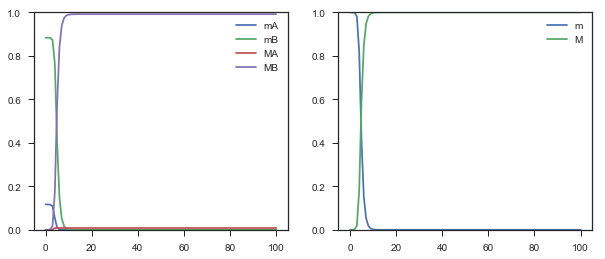

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(xs[:,0], label='mA')
axes[0].plot(xs[:,1], label='mB')
axes[0].plot(xs[:,2], label='MA')
axes[0].plot(xs[:,3], label='MB')
axes[0].legend()
axes[0].set_ylim(0, 1)

axes[1].plot(xs[:,0] + xs[:,1], label='m')
axes[1].plot(xs[:,2] + xs[:,3], label='M')
axes[1].legend()
axes[1].set_ylim(0, 1)

In [24]:
J = dF2(x, W, w, ρ, P, k, l, dx=1e-8)
print(J)
Lex = J[2:, 2:]
print(Lex)

[[  3.96512861e-01  -8.26757184e-02  -4.08222672e+01  -3.59611735e+00]
 [ -3.96519320e-01   8.26761235e-02  -5.38872954e+01  -4.13435361e+00]
 [  1.18186803e-07   9.61604369e-08   6.68695411e+00   5.45809010e-01]
 [  6.97737736e-06   1.35350615e-07   8.80226091e+01   7.18466258e+00]]
[[  6.68695411   0.54580901]
 [ 88.02260914   7.18466258]]


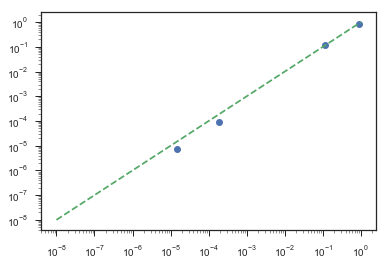

In [25]:
plt.plot(F2(x + 2*dx, W, w, ρ, P, k, l), x + J @ dx, 'o')
plt.yscale('log')
plt.xscale('log')
plt.plot(np.logspace(-8, 0), np.logspace(-8, 0), '--')

In [27]:
def external_stability_matrix(W, w, ρ, P, k, l, dx=1e-8):
    args1 = (W, w, ρ, k, l)
    args2 = (W, w, ρ, P, k, l)
    x1 = stablex1(*args1)
    if not np.allclose(x1, F1(x1, *args1)):
        warnings.warn("Stable x without M wasn't so stable: {}->{}".format(x1, F1(x1, *args1)))
    x = np.array([x1, 1-x1, 0.0, 0.0])
    if not np.allclose(x, F2(x, *args2)):
        warnings.warn("Stable x without M wasn't stable with M: {}->{}".format(x, F2(x, *args2)))
    J = dF2(x, *args2, dx=dx)
    L = J[2:,2:]
    return L
    
def λ1(W, w, ρ, P, k, l, dx=1e-8):
    # np.linalg.eigvals not supported by autograd, using formula
    # the standard formula losses precision, using non-standard
    # see: https://en.wikipedia.org/wiki/Loss_of_significance#Instability_of_the_quadratic_equation
    L = external_stability_matrix(W, w, ρ, P, k, l, dx=dx)
    # L = | L11 L12 |
    #     | L21 L22 |
    L11, L12, L21, L22 = L.ravel()
    # a = 1
    b = -(L11 + L22)
    c = L11 * L22 - L12 * L21
    D = np.sqrt(b**2 - 4*c)
    x1 = (-b - np.sign(b) * D) / 2
    assert np.isreal(x1), x1
    x2 = c / x1
    assert np.isreal(x2), x2
    return np.maximum(x1, x2)
dλ1 = grad(λ1, 3)

Lex = external_stability_matrix(W, w, ρ, P, k, l, dx=1e-8)
np.isclose(λ1(W, w, ρ, P, k, l, dx=1e-8), np.linalg.eigvals(Lex).max())

True

We now calculate $\frac{\partial \lambda_1}{\partial P}$ for different values of $\rho$ and different $(k,l)$ pairs.

In [234]:
W = 1
w = 0.1
ks = [1,2,3]
cols = len(ks)
rows = 5

Calculate and cache:

In [30]:
data = {}
ρs = np.concatenate((
    np.logspace(-6, -1, 25),
    np.linspace(1e-1, 1-1e-1, 50),
    np.logspace(-0.045, -45e-7, 25),
))
for i, k in enumerate(ks):
    for j, l in enumerate(range(k, k+cols)):
        if (k,l) not in data:
            data[(k,l)] = {}
            def λ1_(ρ, P):
                return λ1(W, w, ρ, P, k, l)
            dλ1dP = grad(λ1_, 1)
            data[(k,l)]['ρs'] = ρs
            data[(k,l)]['dλ1s'] = np.array([dλ1dP(ρ, ρ) for ρ in ρs])

/Users/yoavram/miniconda3/envs/Milpitas/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Stable x without M wasn't so stable: 0.4619699531225978->0.4619653234492401
/Users/yoavram/miniconda3/envs/Milpitas/lib/python3.6/site-packages/ipykernel/__main__.py:9: UserWarning: Stable x without M wasn't stable with M: [ 0.46196995  0.53803005  0.          0.        ]->Autograd ArrayNode with value [ 0.46196532  0.53803468  0.          0.        ] and 1 progenitors(s)


In [38]:
np.savez_compressed('../data/AkBl_stable_modifier_w_{}.npz'.format(w), data=data)

Load cache:

In [228]:
with np.load('../data/AkBl_stable_modifier_w_{}.npz'.format(w)) as d:
    data = d['data']
data = data.tolist()

And plot:

In [251]:
def plot_dλ1dP(ρs, dλ1s, ρ1, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(ρs, dλ1s, '-', lw=3)
#     ax.fill_between(ρs, dλ1s, alpha=0.7)
    ax.axhline(0, ls='-', color='k')
    if ρ1 > 1e-4:
        ax.axvline(ρ1, ls='--', color='k', alpha=0.6)
        ax.axvspan(ρ1, 1, color='k', alpha=0.2)
        ax.annotate('$B$ fixation', xy=(ρ1+0.01, 0.1), xycoords='data', fontsize=10,
                    rotation=90, ha='left', va = 'bottom')
    ax.set_xlim(0, 1)
    return ax

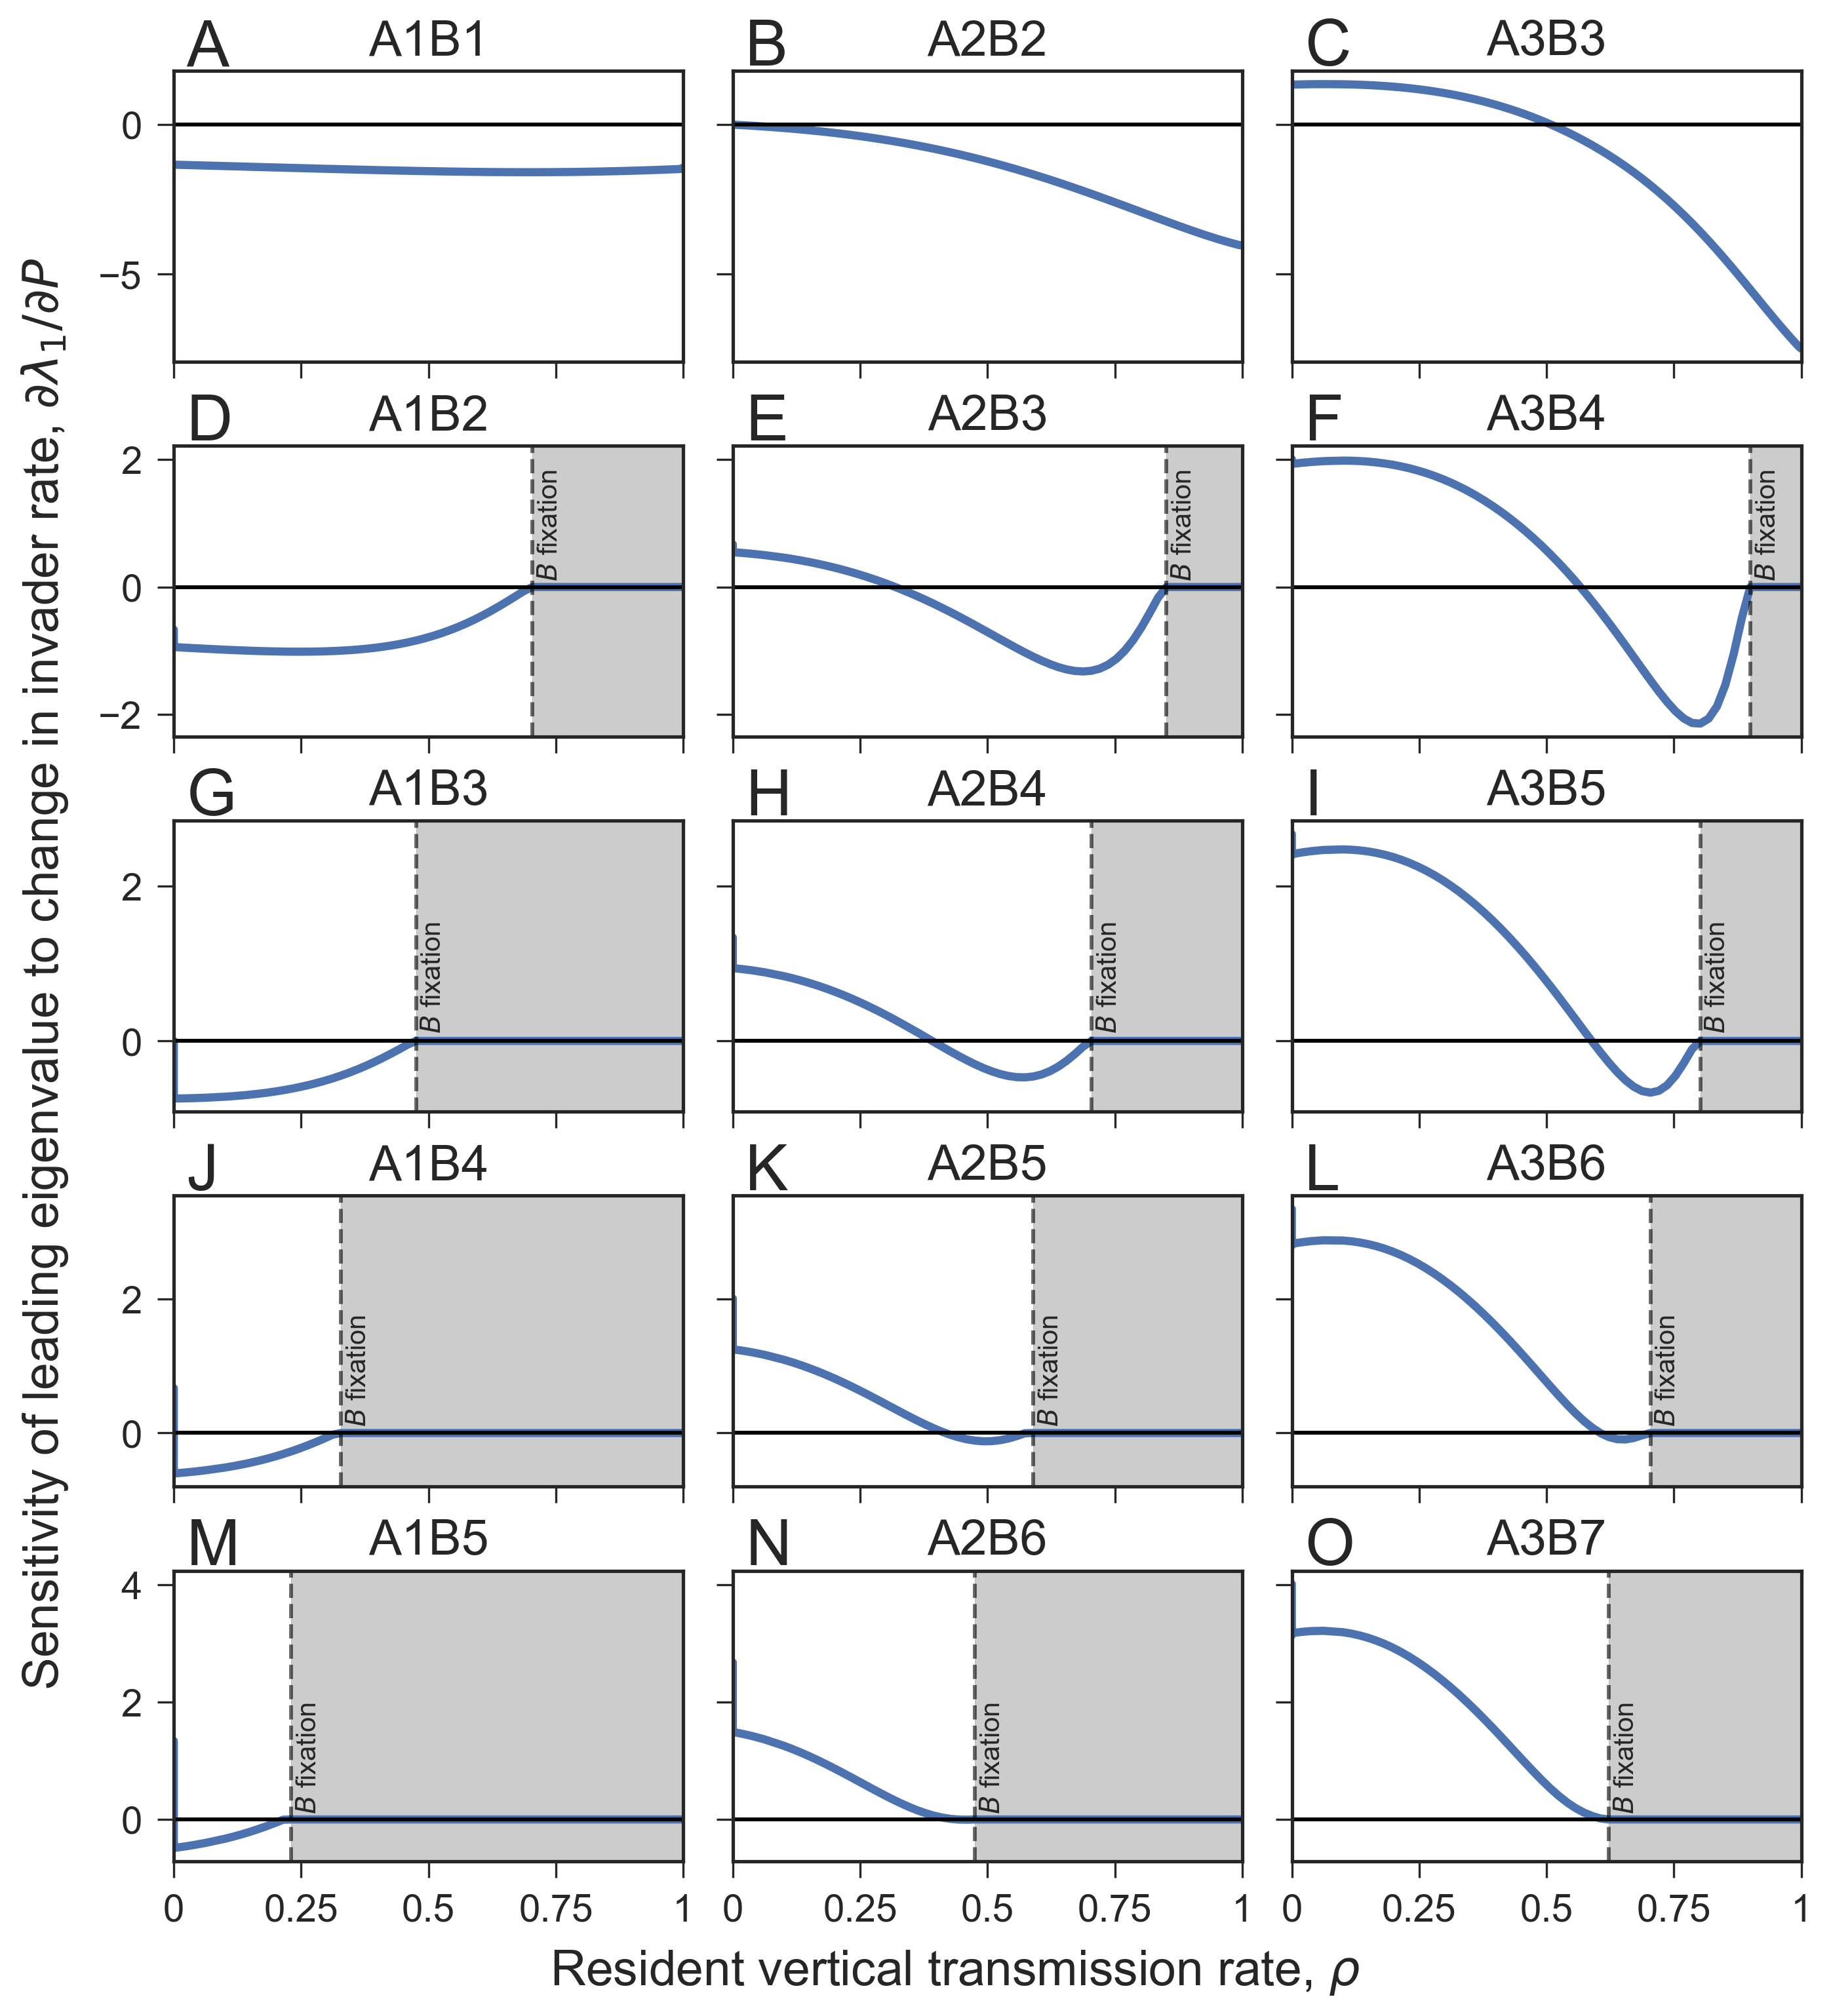

In [252]:
fig, axes = plt.subplots(rows, cols, figsize=(cols*width/2, rows*height/2), sharex=True, sharey='row')

for j, k in enumerate(ks):
    for i, l in enumerate(range(k, k+rows)):
        ρs = data[(k,l)]['ρs']
        ρ1 = ρs[np.argmin([is_polymorphism(w, ρ, k, l) for ρ in ρs])]
        dλ1s = data[(k,l)]['dλ1s']
        plot_dλ1dP(ρs, dλ1s, ρ1, ax=axes[i, j])
        axes[i, j].set_title('A{}B{}'.format(k, l))
        axes[i, j].set_xticks([0,0.25,0.5,0.75,1])
        axes[i, j].set_xticklabels(['0','0.25','0.5','0.75','1'])

labels = fig_panel_labels(axes, ycoord=1.02, xcoord=0.025)
ylabel = fig_ylabel(fig, r'Sensitivity of leading eigenvalue to change in invader rate, $\partial \lambda_1 / \partial P$')
xlabel = fig_xlabel(fig, r'Resident vertical transmission rate, $\rho$', ycoord=-0.02)
# sns.despine()
fig.tight_layout()
fig.savefig("../figures/AkBl_stable_modifier_w_{}.pdf".format(w), **savefig_bbox(xlabel, ylabel, *labels))
fig.savefig("../figures/AkBl_stable_modifier_w_{}.png".format(w), **savefig_bbox(xlabel, ylabel, *labels))